# Import Module

In [14]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing

# Settings

### Variables

In [2]:
variables = ['tas']
variable = 'tas'
TITLE = 'Surface Temperature'
ylabel = '$E_{tas}$ (K)'

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
path_files='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/'

### List of members

In [4]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

# Functions

In [5]:
def get_3D_tas_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    tas = df['tas']
    
    return tas

# Get data : obs, PPE, p1

In [6]:
product = 'BEST'
path_observation = '/data/scratch/globc/peatier/obs_data/BEST/'
filename = 'Land_and_Ocean_LatLong1_regrid_1979-1981.nc'
variable_obs = ['climatology', 'temperature']

In [7]:
# POUR LES OBSERVATIONS BEST

path = path_observation

file =  xr.open_mfdataset(path+filename,combine='by_coords')
clim = file['climatology'].to_dataframe()#.drop(columns='month_number')
clim = pd.concat([clim, clim, clim]).reset_index('month_number')

df_obs=file['temperature'].to_dataframe().reset_index('time')
df_obs['temperature'] = df_obs['temperature']
df_obs['clim'] = clim['climatology']+273.15
df_obs['ta'] = df_obs['temperature']+df_obs['clim']
variable_obs = 'ta'
df_obs

time  temperature        clim          ta
lat        lon                                                   
-88.927735 0.00000    1979.0     0.768801  247.956879  248.725677
           1.40625    1979.0     0.769734  247.934448  248.704178
           2.81250    1979.0     0.770550  247.913254  248.683807
           4.21875    1979.0     0.771259  247.893265  248.664520
           5.62500    1979.0     0.771860  247.873901  248.645767
...                      ...          ...         ...         ...
 88.927735 352.96875  1981.0     0.004460  242.438736  242.443192
           354.37500  1981.0    -0.004911  242.415558  242.410645
           355.78125  1981.0    -0.016334  242.421768  242.405441
           357.18750  1981.0    -0.024906  242.446747  242.421844
           358.59375  1981.0    -0.041427  242.496857  242.455429

[1179648 rows x 4 columns]

In [8]:
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:      (lat: 128, lon: 256)
Coordinates:
  * lat          (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon          (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    time         (lat, lon) float64 1.98e+03 1.98e+03 ... 1.98e+03 1.98e+03
    temperature  (lat, lon) float32 0.17527 0.17550375 ... -0.16200545
    clim         (lat, lon) float32 226.26932 226.22813 ... 253.36414 253.36504
    ta           (lat, lon) float32 226.4446 226.40364 ... 253.20612 253.20302

In [9]:
# Default simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_tas_xarr(path, filename, variables)

In [10]:
# PPE amip simulations 
filename='*_amip_*.nc'

N=len(nb_p_list)
amip={}
i = 0
while i<N:
    nb_p = nb_p_list[i]
    #print(nb_p)
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_tas_xarr(path, filename, variables)
    i=i+1

In [11]:
amip['p1'] = p1_amip

# Calcule full RMSE (ej)

In [59]:
# Reference p1
diff = (amip['p1'].values - obs['ta'].values)**2
diff_p1 = sqrt(sum(diff)/(128*256))

In [60]:
ej = {}
ej['p1'] = diff_p1

for p in nb_p_list :
    diff = (amip[p].values - obs['ta'].values)**2
    diff = sqrt(sum(diff)/(128*256))
    ej[p] = diff

### Save

In [63]:
np.save(path_files+'npy/CNRMppe_decomposition_ej_'+str(variable)+'.npy', ej)

# EOF + truncated RMSE (rj)

## EOF

In [23]:
n=len(nb_p_list)
amip_list=[0]*(n+1)

amip_list[0] = amip['p1']

i = 0
while i<n:
    nb_p = nb_p_list[i]
    #print(nb_p)
    tmp = amip[str(nb_p)]
    amip_list[i+1] = tmp
    i+=1

In [24]:
matrix = xr.combine_nested(amip_list, concat_dim=['time'])

In [25]:
# Mean wheigted with cos(lat) : 
lats = matrix['lat'][:]
coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
wgts = np.sqrt(coslat).drop(labels='height').values
W =wgts[np.newaxis,:,np.newaxis]
#W

In [26]:
# Compute anomalies by removing the ensemble-mean.
mean = matrix.mean(axis=0)
anom = matrix - mean
anom

<xarray.DataArray 'tas' (time: 103, lat: 128, lon: 256)>
dask.array<sub, shape=(103, 128, 256), dtype=float32, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
Dimensions without coordinates: time

In [37]:
# Create an EOF solver to do the EOF analysis. 
solver = Eof(anom, weights=W)

eof = solver.eofsAsCovariance(neofs=100, pcscaling=1)
pc = solver.pcs(pcscaling=1)

In [38]:
varFrac = solver.varianceFraction(neigs=100)
varFrac

<xarray.DataArray 'variance_fractions' (mode: 100)>
array([5.9029305e-01, 1.4316060e-01, 5.8639932e-02, 3.0417012e-02,
       2.7830809e-02, 2.0018833e-02, 1.5256711e-02, 9.8949242e-03,
       7.9678707e-03, 7.0996899e-03, 6.3989810e-03, 5.5999518e-03,
       4.5344974e-03, 4.2321393e-03, 4.0031751e-03, 3.8185476e-03,
       3.4057831e-03, 2.7416931e-03, 2.6190148e-03, 2.5470916e-03,
       2.3622308e-03, 2.2444220e-03, 2.1581822e-03, 1.9745117e-03,
       1.7877818e-03, 1.7275190e-03, 1.6221184e-03, 1.4282162e-03,
       1.3880377e-03, 1.3315770e-03, 1.2468399e-03, 1.2089929e-03,
       1.0711218e-03, 1.0115474e-03, 9.8803267e-04, 9.7136275e-04,
       9.5645763e-04, 8.6397066e-04, 8.3875482e-04, 8.0711144e-04,
       7.7542005e-04, 7.6765771e-04, 7.4538821e-04, 7.1873807e-04,
       7.1063492e-04, 6.3767197e-04, 6.3141389e-04, 5.9365534e-04,
       5.8057794e-04, 5.6045078e-04, 5.5315130e-04, 5.2859902e-04,
       5.1176507e-04, 4.8493716e-04, 4.7884620e-04, 4.6637168e-04,
       4.5231136e-04, 4.4672732e-04, 4.1803138e-04, 3.9737250e-04,
       3.9587688e-04, 3.8457071e-04, 3.7593566e-04, 3.5383605e-04,
       3.4611364e-04, 3.3720530e-04, 3.2054540e-04, 3.1028417e-04,
       3.0553038e-04, 3.0291095e-04, 2.9174765e-04, 2.8806971e-04,
       2.8438025e-04, 2.7652876e-04, 2.7166307e-04, 2.6456689e-04,
       2.6163520e-04, 2.5807711e-04, 2.4699260e-04, 2.4326787e-04,
       2.3946667e-04, 2.3011430e-04, 2.2056579e-04, 2.1784770e-04,
       2.1345174e-04, 2.0408374e-04, 2.0285790e-04, 1.8960644e-04,
       1.8809702e-04, 1.8457975e-04, 1.8199846e-04, 1.7813584e-04,
       1.7138205e-04, 1.6767626e-04, 1.5783962e-04, 1.5509324e-04,
       1.5256063e-04, 1.4869872e-04, 1.4154168e-04, 1.4047862e-04],
      dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
Attributes:
    long_name:  variance_fractions

### Save

In [40]:
for i in range(0,len(eof),1) : 
    j = i+1
    # EOFmap
    EOF_df = eof[i].to_dataframe().drop(labels = 'mode', axis=1)
    EOF_df.to_pickle(path_files+"npy/CNRMppe_decomposition_EOFmap"+str(j)+"_"+str(variable)+".npy")
    
    #EOFpc
    pc_p1 = pc[0, i]
    pc_mb = pc[1:, i]
    np.save(path_files+'npy/CNRMppe_decomposition_p1_EOF'+str(j)+'pc_'+str(variable)+'.npy', pc_p1)
    np.save(path_files+'npy/CNRMppe_decomposition_EOF'+str(j)+'pc_'+str(variable)+'.npy', pc_mb)

In [168]:
mean_df = mean.to_dataframe(name=str(variable)+'mean').drop(labels = 'height', axis=1)
mean_df.to_pickle(path_files+'npy/CNRMppe_decomposition_mean_'+str(variable)+'.npy')

## Projection des obs

In [187]:
eofs = []
pc1 = np.load(path_files+'npy/CNRMppe_decomposition_EOF1pc_'+str(variable)+'.npy')
PC_df = pd.DataFrame(pc1)
PC_df['pc1'] = pc1

for i in range(0,5, 1) :
    j=i+1
    tmp = pd.read_pickle(path_files+'npy/CNRMppe_decomposition_EOFmap'+str(j)+'_'+str(variable)+'.npy').to_xarray().to_array()
    tmp_bis = tmp[0,:,:].rename({'variable':'mode'})
    eofs.append(tmp_bis)

    pc = np.load(path_files+'npy/CNRMppe_decomposition_EOF'+str(j)+'pc_'+str(variable)+'.npy')
    PC_df['pc'+str(j)] = pc

eofs_combined = xr.combine_nested(eofs, concat_dim='eofs')
PC_df = PC_df.drop(labels = 0, axis=1)

In [188]:
eofs_inv = np.linalg.pinv(eofs_combined.transpose())

In [189]:
Mean =  pd.read_pickle(path_files+'npy/CNRMppe_decomposition_mean_'+str(variable)+'.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})
X_obs = obs['ta'] - Mean
X_obs_bis = X_obs.expand_dims(dim={'dummy':range(0,102,1)})
X_obs_bis

<xarray.DataArray (dummy: 102, lat: 128, lon: 256)>
array([[[ 0.9802704 ,  0.9393158 ,  0.90057373, ...,  1.1010437 ,
          1.0620728 ,  1.0218506 ],
        [ 0.33155823,  0.24545288,  0.11924744, ...,  0.5418396 ,
          0.4684906 ,  0.4024353 ],
        [ 1.2012634 ,  1.1326752 ,  1.0542145 , ...,  1.0857544 ,
          1.3535614 ,  1.2684479 ],
        ...,
        [-3.0155945 , -3.000702  , -2.9854126 , ..., -3.0026093 ,
         -3.0451965 , -3.030716  ],
        [-2.5655518 , -2.5644073 , -2.5596313 , ..., -2.5480347 ,
         -2.5565033 , -2.563202  ],
        [-1.0388489 , -1.040863  , -1.0423584 , ..., -1.029602  ,
         -1.0331879 , -1.0362854 ]],

       [[ 0.9802704 ,  0.9393158 ,  0.90057373, ...,  1.1010437 ,
          1.0620728 ,  1.0218506 ],
        [ 0.33155823,  0.24545288,  0.11924744, ...,  0.5418396 ,
          0.4684906 ,  0.4024353 ],
        [ 1.2012634 ,  1.1326752 ,  1.0542145 , ...,  1.0857544 ,
          1.3535614 ,  1.2684479 ],
        ...,
        [-3.0155945 , -3.000702  , -2.9854126 , ..., -3.0026093 ,
         -3.0451965 , -3.030716  ],
        [-2.5655518 , -2.5644073 , -2.5596313 , ..., -2.5480347 ,
         -2.5565033 , -2.563202  ],
        [-1.0388489 , -1.040863  , -1.0423584 , ..., -1.029602  ,
         -1.0331879 , -1.0362854 ]],

       [[ 0.9802704 ,  0.9393158 ,  0.90057373, ...,  1.1010437 ,
          1.0620728 ,  1.0218506 ],
        [ 0.33155823,  0.24545288,  0.11924744, ...,  0.5418396 ,
          0.4684906 ,  0.4024353 ],
        [ 1.2012634 ,  1.1326752 ,  1.0542145 , ...,  1.0857544 ,
          1.3535614 ,  1.2684479 ],
        ...,
        [-3.0155945 , -3.000702  , -2.9854126 , ..., -3.0026093 ,
         -3.0451965 , -3.030716  ],
        [-2.5655518 , -2.5644073 , -2.5596313 , ..., -2.5480347 ,
         -2.5565033 , -2.563202  ],
        [-1.0388489 , -1.040863  , -1.0423584 , ..., -1.029602  ,
         -1.0331879 , -1.0362854 ]],

       ...,

       [[ 0.9802704 ,  0.9393158 ,  0.90057373, ...,  1.1010437 ,
          1.0620728 ,  1.0218506 ],
        [ 0.33155823,  0.24545288,  0.11924744, ...,  0.5418396 ,
          0.4684906 ,  0.4024353 ],
        [ 1.2012634 ,  1.1326752 ,  1.0542145 , ...,  1.0857544 ,
          1.3535614 ,  1.2684479 ],
        ...,
        [-3.0155945 , -3.000702  , -2.9854126 , ..., -3.0026093 ,
         -3.0451965 , -3.030716  ],
        [-2.5655518 , -2.5644073 , -2.5596313 , ..., -2.5480347 ,
         -2.5565033 , -2.563202  ],
        [-1.0388489 , -1.040863  , -1.0423584 , ..., -1.029602  ,
         -1.0331879 , -1.0362854 ]],

       [[ 0.9802704 ,  0.9393158 ,  0.90057373, ...,  1.1010437 ,
          1.0620728 ,  1.0218506 ],
        [ 0.33155823,  0.24545288,  0.11924744, ...,  0.5418396 ,
          0.4684906 ,  0.4024353 ],
        [ 1.2012634 ,  1.1326752 ,  1.0542145 , ...,  1.0857544 ,
          1.3535614 ,  1.2684479 ],
        ...,
        [-3.0155945 , -3.000702  , -2.9854126 , ..., -3.0026093 ,
         -3.0451965 , -3.030716  ],
        [-2.5655518 , -2.5644073 , -2.5596313 , ..., -2.5480347 ,
         -2.5565033 , -2.563202  ],
        [-1.0388489 , -1.040863  , -1.0423584 , ..., -1.029602  ,
         -1.0331879 , -1.0362854 ]],

       [[ 0.9802704 ,  0.9393158 ,  0.90057373, ...,  1.1010437 ,
          1.0620728 ,  1.0218506 ],
        [ 0.33155823,  0.24545288,  0.11924744, ...,  0.5418396 ,
          0.4684906 ,  0.4024353 ],
        [ 1.2012634 ,  1.1326752 ,  1.0542145 , ...,  1.0857544 ,
          1.3535614 ,  1.2684479 ],
        ...,
        [-3.0155945 , -3.000702  , -2.9854126 , ..., -3.0026093 ,
         -3.0451965 , -3.030716  ],
        [-2.5655518 , -2.5644073 , -2.5596313 , ..., -2.5480347 ,
         -2.5565033 , -2.563202  ],
        [-1.0388489 , -1.040863  , -1.0423584 , ..., -1.029602  ,
         -1.0331879 , -1.0362854 ]]], dtype=float32)
Coordinates:
  * dummy    (dummy) int64 0 1 2 3 4 5 6 7 8 9 ... 93 94 95 96 97 98 99 100 101
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 

In [190]:
U_obs = np.dot(eofs_inv,X_obs_bis.transpose('lon','lat', 'dummy'))
U_obs_bis = xr.DataArray(U_obs, dims=['lon','eofs','lon2', 'dummy'])
U_obs_avg = U_obs_bis[0,:,0,0].transpose()
U_obs_avg

<xarray.DataArray (eofs: 5)>
array([-0.09274242, -1.3749883 , -0.09347625,  1.5416942 ,  3.8224268 ],
      dtype=float32)
Dimensions without coordinates: eofs

### Save

In [191]:
np.save(path_files+'npy/CNRMppe_decomposition_U_'+str(product)+'.npy', U_obs_avg)

## Calcule de rj

In [192]:
U_obs = np.load(path_files+'npy/CNRMppe_decomposition_U_'+str(product)+'.npy')
len(U_obs)

5

In [193]:
def Error_rj(cpt, U_obs, variable):
    rj_list = []
    for i in range(0,5,1) :
        j=i+1
        pc = np.load(path_files+'npy/CNRMppe_decomposition_EOF'+str(j)+'pc_'+str(variable)+'.npy')
        diff = (pc[cpt]-U_obs[i])**2
        rj_list.append(diff)
        #print(pc[cpt])
        #print(U_obs[i])
        #print(diff)
    rj_E = sqrt(sum(rj_list)/len(rj_list))
    return rj_E

In [194]:
U_obs = np.load(path_files+'npy/CNRMppe_decomposition_U_'+str(product)+'.npy')
rj = {}
cpt=0
for p in nb_p_list:
    tmp = Error_rj(cpt, U_obs, variable)
    rj[p] = tmp
    cpt+=1

# Emulation

# Figure

In [195]:
ej_list = []
rj_list = []
for p in nb_p_list :
    ej_tmp = ej[p]
    rj_tmp = rj[p]
    ej_list.append(ej_tmp)
    rj_list.append(rj_tmp)
    
df_corr = pd.DataFrame(ej_list, columns=['ej'])
df_corr['rj'] = rj_list
df_corr

,ej,rj
0,1.596653,1.055966
1,1.800415,2.821711
2,2.357326,1.710921
3,1.808246,2.530649
4,1.684001,1.557580
...,...,...
97,1.893827,2.522954
98,2.256450,2.755906
99,1.812770,2.746495
100,2.245847,2.584486


In [196]:
r_corr = np.corrcoef(df_corr['ej'], df_corr['rj'])
r_corr

array([[1.        , 0.43731862],
       [0.43731862, 1.        ]])

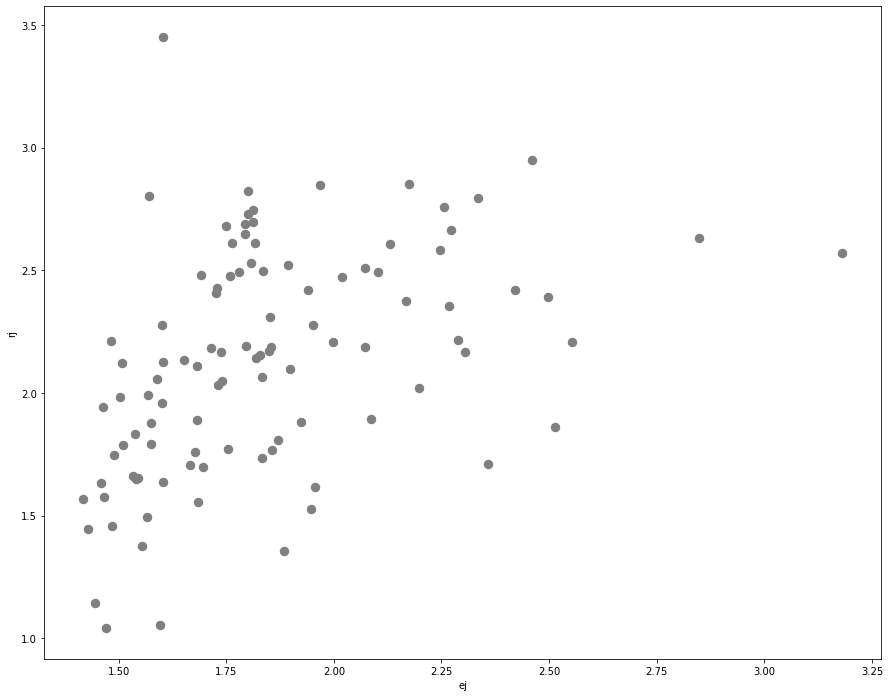

In [197]:
df_corr.plot(kind='scatter', x='ej', y='rj', color = 'gray', alpha=1, linewidth=5, figsize=(15, 12))